In [1]:
from src.database import IngredientsDatabase, EffectsDatabase
from src.inventory import Inventory
from src.player import Player
from src.ingredient import Ingredient
from src.alchemy_simulator import AlchemySimulator

import numpy as np
import time

In [2]:
effects_db = EffectsDatabase()
ing_db = IngredientsDatabase()

In [3]:
ing = ing_db["Small Antlers"]
print(ing)

for effect_name in ing.get_effect_names():
    effect = effects_db.ingredient_effect(effect_name, ing)
    real = effect.realize(Player())
    print(real.value)

Ingredient('Small Antlers', value=2, weight=0.1, effects=['Weakness to Poison', 'Fortify Restoration', 'Lingering Damage Stamina', 'Damage Health'])
37
80
8
2


In [4]:
# calculate effect frequencies
effects_data = {}
total = len(ing_db)

for ing in ing_db:
    effect_names = ing.get_effect_names()
    for effect_name in effect_names:
        effect = effects_db.ingredient_effect(effect_name, ing)
        realized = effect.realize(Player())
        value = realized.value
        if effect_name not in effects_data:
            effects_data[effect_name] = { 
                "count": 1,
                "total_value": value
            }
        else:
            effects_data[effect_name]["count"] += 1
            effects_data[effect_name]["total_value"] += value


            
for effect_name, data in effects_data.items():
    avg_value = data["total_value"] / data["count"]
    frequency = data["count"] / total
    utility_score = avg_value * frequency
    new_data = {"avg_value": avg_value, "frequency": frequency, "utility": utility_score}
    effects_data[effect_name] = data | new_data

max_value = max(data["avg_value"] for data in effects_data.values())
        
for effect, data in sorted(effects_data.items(), key=lambda x: x[1]["utility"]):
    print("\t" + effect + ":\n-----------------")
    print("count: " + str(data["count"]))
    print("avg value: " + str(data["avg_value"]))
    print("utility: " + str(data["utility"]))
    print("\n\n")


	Lingering Damage Stamina:
-----------------
count: 5
avg value: 8.0
utility: 0.36036036036036034



	Ravage Health:
-----------------
count: 7
avg value: 6.0
utility: 0.37837837837837834



	Cure Disease:
-----------------
count: 5
avg value: 8.6
utility: 0.38738738738738737



	Fortify Enchanting:
-----------------
count: 7
avg value: 9.0
utility: 0.5675675675675675



	Fortify Lockpicking:
-----------------
count: 5
avg value: 18.0
utility: 0.8108108108108107



	Ravage Magicka:
-----------------
count: 8
avg value: 13.25
utility: 0.954954954954955



	Fortify Barter:
-----------------
count: 4
avg value: 30.0
utility: 1.0810810810810811



	Fortify Alteration:
-----------------
count: 4
avg value: 32.0
utility: 1.1531531531531531



	Ravage Stamina:
-----------------
count: 7
avg value: 20.0
utility: 1.2612612612612613



	Weakness to Frost:
-----------------
count: 6
avg value: 26.333333333333332
utility: 1.4234234234234235



	Fortify Heavy Armor:
-----------------
count: 5
avg v

In [5]:
ingredients_data = {}

for ingredient in ing_db:
    # Get this ingredient's effects as a set for fast intersection
    ing_effects = set(ingredient.get_effect_names())
    
    # Track synergy levels
    synergy_counts = {
        "at_least_1": 0,  # Ingredients sharing 1+ effects
        "exactly_2": 0,   # Ingredients sharing exactly 2 effects
        "exactly_3": 0,   # Ingredients sharing exactly 3 effects
        "exactly_4": 0    # Ingredients sharing all 4 effects (rare!)
    }
    
    # Track ingredient names for each synergy level (2+ effects only)
    synergy_partners = {
        "exactly_2": [],
        "exactly_3": [],
        "exactly_4": []
    }
    
    # Compare with every other ingredient
    for other_ingredient in ing_db:
        if other_ingredient.name == ingredient.name:
            continue  # Skip self-comparison
        
        other_effects = set(other_ingredient.get_effect_names())
        shared_count = len(ing_effects & other_effects)  # Set intersection
        
        if shared_count >= 1:
            synergy_counts["at_least_1"] += 1
        if shared_count == 2:
            synergy_counts["exactly_2"] += 1
            synergy_partners["exactly_2"].append(other_ingredient.name)
        if shared_count == 3:
            synergy_counts["exactly_3"] += 1
            synergy_partners["exactly_3"].append(other_ingredient.name)
        if shared_count == 4:
            synergy_counts["exactly_4"] += 1
            synergy_partners["exactly_4"].append(other_ingredient.name)
    
    # Calculate value and utility metrics
    total_value = 0
    total_utility = 0
    for effect_name in ingredient.get_effect_names():
        effect = effects_db.ingredient_effect(effect_name, ingredient)
        realized = effect.realize(Player())
        total_value += realized.value
        total_utility += effects_data[effect_name]["utility"]
    
    avg_utility = total_utility / 4
    
    ingredients_data[ingredient.name] = {
        "synergy_at_least_1": synergy_counts["at_least_1"],
        "synergy_exactly_2": synergy_counts["exactly_2"],
        "synergy_exactly_3": synergy_counts["exactly_3"],
        "synergy_exactly_4": synergy_counts["exactly_4"],
        "partners_exactly_2": synergy_partners["exactly_2"],
        "partners_exactly_3": synergy_partners["exactly_3"],
        "partners_exactly_4": synergy_partners["exactly_4"],
        "total_value": total_value,
        "avg_utility": avg_utility
    }

# Print sorted by synergy potential (ingredients with most 2+ shared effects)
print("Top ingredients by synergy (2+ shared effects):")
print("=" * 70)
i = 0
for name, data in sorted(ingredients_data.items(), 
                          key=lambda x: x[1]["synergy_exactly_2"] + x[1]["synergy_exactly_3"] + x[1]["synergy_exactly_4"], 
                          reverse=True)[:50]:
    i += 1
    print(f"\n{i}. {name}:")
    print(f"  Synergy at least 1 effect: {data['synergy_at_least_1']}")
    print(f"  Synergy exactly 2 effects: {data['synergy_exactly_2']}")
    if data['partners_exactly_2']:
        print(f"    Partners: {', '.join(data['partners_exactly_2'][:5])}" + 
              (f" ... (+{len(data['partners_exactly_2'])-5} more)" if len(data['partners_exactly_2']) > 5 else ""))
    print(f"  Synergy exactly 3 effects: {data['synergy_exactly_3']}")
    if data['partners_exactly_3']:
        print(f"    Partners: {', '.join(data['partners_exactly_3'])}")
    print(f"  Synergy exactly 4 effects: {data['synergy_exactly_4']}")
    if data['partners_exactly_4']:
        print(f"    Partners: {', '.join(data['partners_exactly_4'])}")
    print(f"  Total value: {data['total_value']}")
    print(f"  Avg utility: {data['avg_utility']:.2f}")

Top ingredients by synergy (2+ shared effects):

1. Jarrin Root:
  Synergy at least 1 effect: 46
  Synergy exactly 2 effects: 9
    Partners: Ancestor Moth Wing, Blue Butterfly Wing, Chaurus Hunter Antennae, Crimson Nirnroot, Glow Dust ... (+4 more)
  Synergy exactly 3 effects: 1
    Partners: Human Heart
  Synergy exactly 4 effects: 0
  Total value: 656
  Avg utility: 9.80

2. Dwarven Oil:
  Synergy at least 1 effect: 24
  Synergy exactly 2 effects: 7
    Partners: Creep Cluster, Fire Salts, Jazbay Grapes, Moon Sugar, Mora Tapinella ... (+2 more)
  Synergy exactly 3 effects: 0
  Synergy exactly 4 effects: 1
    Partners: Taproot
  Total value: 244
  Avg utility: 4.31

3. Hawk Beak:
  Synergy at least 1 effect: 38
  Synergy exactly 2 effects: 8
    Partners: Netch Jelly, Pearl, Pine Thrush Egg, Purple Mountain Flower, Silverside Perch ... (+3 more)
  Synergy exactly 3 effects: 0
  Synergy exactly 4 effects: 0
  Total value: 279
  Avg utility: 9.12

4. Human Heart:
  Synergy at least 1 

In [7]:
db = ing_db

inv = Inventory.generate_random_weighted(db, size=10)

for ingredient in inv.get_available_ingredients():
    print(f"{ingredient} x {inv.get_quantity(ingredient)}")

Canis Root x 1
Burnt Spriggan Wood x 1
Hawk Feathers x 4
Small Antlers x 4
Dwarven Oil x 2
Chicken Egg x 2
Hawk's Egg x 1
Hagraven Claw x 1
Nordic Barnacle x 4
Deathbell x 9


In [8]:
alembic = AlchemySimulator.from_base_player()
db = IngredientsDatabase()
results = []  # Initialize results list
start_time = time.time()
for i in range(20):  # Reduced from 1M for testing
    # size = np.random.randint(3, 50)
    size = 20
    inv = Inventory.generate_normal(db, size=size)
    alembic.set_inventory(inv)
    print(f"iter {i} --- {(time.time() - start_time)} seconds --- " )
    results.append(alembic.exhaust_inventory(strategy="greedy-basic"))
    alembic.delete_inventory()

print(f"Completed {len(results)} simulations")
print(f"Average potions per run: {sum(len(r) for r in results) / len(results):.2f}")

iter 0 --- 0.03625798225402832 seconds --- 
iter 1 --- 0.27708005905151367 seconds --- 
iter 2 --- 0.6911048889160156 seconds --- 
iter 3 --- 1.066335916519165 seconds --- 
iter 4 --- 1.5119171142578125 seconds --- 
iter 5 --- 1.7789082527160645 seconds --- 
iter 6 --- 1.9208300113677979 seconds --- 
iter 7 --- 2.184487819671631 seconds --- 
iter 8 --- 2.4273788928985596 seconds --- 
iter 9 --- 2.755392074584961 seconds --- 
iter 10 --- 3.104377031326294 seconds --- 
iter 11 --- 3.535346269607544 seconds --- 
iter 12 --- 4.097710132598877 seconds --- 
iter 13 --- 4.464250087738037 seconds --- 
iter 14 --- 4.68502402305603 seconds --- 
iter 15 --- 4.925148963928223 seconds --- 
iter 16 --- 5.261011838912964 seconds --- 
iter 17 --- 6.102419853210449 seconds --- 
iter 18 --- 6.842345952987671 seconds --- 
iter 19 --- 7.064434051513672 seconds --- 
Completed 20 simulations
Average potions per run: 40.80


In [9]:
for result in results:
    print("\tinventory results:\n\t==================\n")
    for potion in result:
        
        potion.print_self()
        

	inventory results:

Poison of Slow
Ingredients: Large Antlers, Poison Bloom, Creep Cluster
Total Value: 431 gold
Number of Effects: 3

Effects:
  - Target moves at 50% speed for 22 seconds.
  - Decrease the target's Stamina regeneration by 100% for 22 seconds.
  - Carrying capacity increases by 17 for 300 seconds.
Poison of Slow
Ingredients: Large Antlers, Poison Bloom, Creep Cluster
Total Value: 431 gold
Number of Effects: 3

Effects:
  - Target moves at 50% speed for 22 seconds.
  - Decrease the target's Stamina regeneration by 100% for 22 seconds.
  - Carrying capacity increases by 17 for 300 seconds.
Poison of Slow
Ingredients: Large Antlers, Creep Cluster, Trama Root
Total Value: 431 gold
Number of Effects: 3

Effects:
  - Target moves at 50% speed for 22 seconds.
  - Decrease the target's Stamina regeneration by 100% for 22 seconds.
  - Carrying capacity increases by 17 for 300 seconds.
Poison of Slow
Ingredients: Large Antlers, Creep Cluster, Trama Root
Total Value: 431 gold
Nu

# Monte Carlo Analysis - Phase 2

## Section 1: Simulation Infrastructure

In [10]:
# Monte Carlo Configuration
MC_CONFIG = {
    'num_runs': 1000,
    'strategies': ['greedy-basic'],
    'inventory_strategies': ['normal', 'random_weighted', 'vendor'],
    'inventory_sizes': [10, 20, 35, 50],
    'player_archetypes': {
        'novice': {
            'alchemy_skill': 15,
            'alchemist_perk': 0,
            'fortify_alchemy': 0,
            'physician_perk': False,
            'benefactor_perk': False,
            'poisoner_perk': False,
            'seeker_of_shadows': False,
            'purity_perk': False
        },
        'poisoner': {
            'alchemy_skill': 100,
            'alchemist_perk': 100,
            'fortify_alchemy': 0,
            'physician_perk': False,
            'benefactor_perk': False,
            'poisoner_perk': True,
            'seeker_of_shadows': False,
            'purity_perk': False
        },
        'benefactor': {
            'alchemy_skill': 100,
            'alchemist_perk': 100,
            'fortify_alchemy': 0,
            'physician_perk': False,
            'benefactor_perk': True,
            'poisoner_perk': False,
            'seeker_of_shadows': False,
            'purity_perk': False
        }
    }
}

print(f"Monte Carlo Configuration:")
print(f"  Runs: {MC_CONFIG['num_runs']}")
print(f"  Inventory strategies: {', '.join(MC_CONFIG['inventory_strategies'])}")
print(f"  Inventory sizes: {MC_CONFIG['inventory_sizes']}")
print(f"  Player archetypes: {', '.join(MC_CONFIG['player_archetypes'].keys())}")

Monte Carlo Configuration:
  Runs: 1000
  Inventory strategies: normal, random_weighted, vendor
  Inventory sizes: [10, 20, 35, 50]
  Player archetypes: novice, poisoner, benefactor


In [11]:
# Result Storage Data Structures
monte_carlo_results = {
    'run_metadata': [],           # List of dicts with inventory composition, strategy, player stats
    'ingredient_tracking': {},    # {ingredient_name: {appearances, usages, values, ...}}
    'effect_tracking': {},        # {effect_name: {potion_appearances, realized_values, ...}}
    'synergy_tracking': {},       # {(ing1, ing2): {co_usages, values}}
    'potion_results': []          # All potions crafted (for archetype analysis)
}

print("Initialized monte_carlo_results storage structure")

Initialized monte_carlo_results storage structure


In [12]:
# Inventory Analysis Helper Functions
def analyze_inventory_composition(inventory, db):
    """Extract rarity/source distribution from inventory"""
    rarity_counts = {'common': 0, 'uncommon': 0, 'rare': 0, 'very_rare': 0, 'unique': 0}
    source_counts = {}
    total_value = 0
    
    for ing_name in inventory:
        ing = db.get_ingredient(ing_name)
        rarity_counts[ing.rarity] += inventory.get_quantity(ing_name)
        source_counts[ing.source] = source_counts.get(ing.source, 0) + inventory.get_quantity(ing_name)
        total_value += ing.value * inventory.get_quantity(ing_name)
    
    return {
        'rarity_dist': rarity_counts,
        'source_dist': source_counts,
        'unique_count': inventory.unique_items(),
        'total_qty': inventory.total_items(),
        'total_base_value': total_value
    }

print("Helper functions defined")

Helper functions defined


## Section 2: Main Monte Carlo Simulation

In [13]:
# Execute Monte Carlo Runs
print(f"Starting {MC_CONFIG['num_runs']} Monte Carlo simulation runs...")
print("=" * 70)

alembic = AlchemySimulator.from_base_player()
start_time = time.time()

for run_idx in range(MC_CONFIG['num_runs']):
    # Rotate through inventory strategies
    inv_strategy = MC_CONFIG['inventory_strategies'][run_idx % len(MC_CONFIG['inventory_strategies'])]
    
    # Rotate through inventory sizes
    size = MC_CONFIG['inventory_sizes'][run_idx % len(MC_CONFIG['inventory_sizes'])]
    
    # Generate inventory based on strategy
    if inv_strategy == 'normal':
        inv = Inventory.generate_normal(ing_db, size=size)
    elif inv_strategy == 'random_weighted':
        inv = Inventory.generate_random_weighted(ing_db, size=size)
    elif inv_strategy == 'vendor':
        inv = Inventory.generate_vendor(ing_db)
    
    # Analyze inventory before consumption
    inv_composition = analyze_inventory_composition(inv, ing_db)
    
    # Store initial inventory snapshot
    initial_inventory = {name: inv.get_quantity(name) for name in inv}
    
    # Run alchemy simulation (greedy-basic strategy)
    alembic.set_inventory(inv)
    potions_crafted = alembic.exhaust_inventory(strategy="greedy-basic")
    
    # Calculate ingredient consumption
    final_inventory = {name: alembic._inventory.get_quantity(name) for name in initial_inventory}
    consumed = {name: initial_inventory[name] - final_inventory.get(name, 0) 
                for name in initial_inventory}
    
    # Store run metadata
    monte_carlo_results['run_metadata'].append({
        'run_id': run_idx,
        'inv_strategy': inv_strategy,
        'inv_size': size,
        'inv_composition': inv_composition,
        'potions_count': len(potions_crafted),
        'total_value': sum(p.total_value for p in potions_crafted)
    })
    
    # Track ingredient performance
    for ing_name in initial_inventory:
        if ing_name not in monte_carlo_results['ingredient_tracking']:
            monte_carlo_results['ingredient_tracking'][ing_name] = {
                'appearances': 0,
                'usages': 0,
                'quantities_available': [],
                'quantities_consumed': [],
                'potions_participated': [],
                'value_contributions': []
            }
        
        monte_carlo_results['ingredient_tracking'][ing_name]['appearances'] += 1
        monte_carlo_results['ingredient_tracking'][ing_name]['quantities_available'].append(
            initial_inventory[ing_name]
        )
        
        if consumed[ing_name] > 0:
            monte_carlo_results['ingredient_tracking'][ing_name]['usages'] += 1
            monte_carlo_results['ingredient_tracking'][ing_name]['quantities_consumed'].append(
                consumed[ing_name]
            )
            
            # Track which potions used this ingredient
            potions_with_ing = [p for p in potions_crafted if ing_name in p.ingredient_names]
            monte_carlo_results['ingredient_tracking'][ing_name]['potions_participated'].append(
                len(potions_with_ing)
            )
            monte_carlo_results['ingredient_tracking'][ing_name]['value_contributions'].append(
                sum(p.total_value for p in potions_with_ing)
            )
    
    # Track effect performance in actual potions
    for potion in potions_crafted:
        for effect in potion.realized_effects:
            if effect.name not in monte_carlo_results['effect_tracking']:
                monte_carlo_results['effect_tracking'][effect.name] = {
                    'potion_appearances': 0,
                    'realized_values': [],
                    'realized_magnitudes': [],
                    'realized_durations': []
                }
            
            monte_carlo_results['effect_tracking'][effect.name]['potion_appearances'] += 1
            monte_carlo_results['effect_tracking'][effect.name]['realized_values'].append(effect.value)
            monte_carlo_results['effect_tracking'][effect.name]['realized_magnitudes'].append(effect.magnitude)
            monte_carlo_results['effect_tracking'][effect.name]['realized_durations'].append(effect.duration)
    
    # Track synergy pair co-occurrence and usage
    for potion in potions_crafted:
        for i, ing1 in enumerate(potion.ingredient_names):
            for ing2 in potion.ingredient_names[i+1:]:
                pair = tuple(sorted([ing1, ing2]))
                if pair not in monte_carlo_results['synergy_tracking']:
                    monte_carlo_results['synergy_tracking'][pair] = {
                        'co_usages': 0,
                        'values': []
                    }
                monte_carlo_results['synergy_tracking'][pair]['co_usages'] += 1
                monte_carlo_results['synergy_tracking'][pair]['values'].append(potion.total_value)
    
    # Store potion results
    monte_carlo_results['potion_results'].extend(potions_crafted)
    
    # Progress reporting
    if (run_idx + 1) % 100 == 0:
        elapsed = time.time() - start_time
        print(f"Completed {run_idx + 1}/{MC_CONFIG['num_runs']} runs in {elapsed:.1f}s")
    
    alembic.delete_inventory()

total_time = time.time() - start_time
print(f"\nTotal simulation time: {total_time:.1f}s")
print(f"Average time per run: {total_time / MC_CONFIG['num_runs']:.3f}s")
print(f"Total potions crafted: {len(monte_carlo_results['potion_results'])}")

Starting 1000 Monte Carlo simulation runs...
Completed 100/1000 runs in 257.2s
Completed 200/1000 runs in 511.4s
Completed 300/1000 runs in 758.1s
Completed 400/1000 runs in 1012.9s
Completed 500/1000 runs in 1279.1s
Completed 600/1000 runs in 6955.6s
Completed 700/1000 runs in 15521.3s
Completed 800/1000 runs in 16469.1s
Completed 900/1000 runs in 16713.3s
Completed 1000/1000 runs in 16978.2s

Total simulation time: 16978.2s
Average time per run: 16.978s
Total potions crafted: 41187


In [14]:
# Compute Aggregate Statistics
print("Computing aggregate statistics...")
print("=" * 70)

# Aggregate ingredient robustness metrics
ingredient_robustness = {}

for ing_name, data in monte_carlo_results['ingredient_tracking'].items():
    appearances = data['appearances']
    usages = data['usages']
    
    ingredient_robustness[ing_name] = {
        'appearance_rate': appearances / MC_CONFIG['num_runs'],
        'usage_rate': usages / appearances if appearances > 0 else 0,
        'avg_qty_available': np.mean(data['quantities_available']) if data['quantities_available'] else 0,
        'avg_qty_consumed': np.mean(data['quantities_consumed']) if data['quantities_consumed'] else 0,
        'avg_potions_per_use': np.mean(data['potions_participated']) if data['potions_participated'] else 0,
        'avg_value_contribution': np.mean(data['value_contributions']) if data['value_contributions'] else 0,
        'std_value_contribution': np.std(data['value_contributions']) if data['value_contributions'] else 0,
        'robustness_score': (usages / appearances) * np.mean(data['value_contributions']) 
                           if appearances > 0 and data['value_contributions'] else 0
    }

# Aggregate effect performance
effect_performance = {}
total_potions = len(monte_carlo_results['potion_results'])

for effect_name, data in monte_carlo_results['effect_tracking'].items():
    effect_performance[effect_name] = {
        'potion_frequency': data['potion_appearances'] / total_potions if total_potions > 0 else 0,
        'avg_realized_value': np.mean(data['realized_values']),
        'std_realized_value': np.std(data['realized_values']),
        'avg_magnitude': np.mean(data['realized_magnitudes']),
        'avg_duration': np.mean(data['realized_durations'])
    }

# Aggregate synergy pair performance
synergy_performance = {}

for pair, data in monte_carlo_results['synergy_tracking'].items():
    synergy_performance[pair] = {
        'co_usage_count': data['co_usages'],
        'avg_pair_value': np.mean(data['values']),
        'std_pair_value': np.std(data['values']),
        'pair_robustness': data['co_usages'] / MC_CONFIG['num_runs']
    }

print(f"Aggregated {len(ingredient_robustness)} ingredients")
print(f"Aggregated {len(effect_performance)} effects")
print(f"Aggregated {len(synergy_performance)} synergy pairs")
print(f"\nTop 5 ingredients by robustness score:")
for i, (ing_name, metrics) in enumerate(sorted(ingredient_robustness.items(), 
                                               key=lambda x: x[1]['robustness_score'], 
                                               reverse=True)[:5], 1):
    print(f"  {i}. {ing_name}: {metrics['robustness_score']:.1f}")

Computing aggregate statistics...
Aggregated 111 ingredients
Aggregated 55 effects
Aggregated 4858 synergy pairs

Top 5 ingredients by robustness score:
  1. Frost Mirriam: 5560.9
  2. Giant Lichen: 4183.8
  3. Jarrin Root: 3908.6
  4. Salmon Roe: 2755.0
  5. Trama Root: 2529.9


## Section 3: Sensitivity Analysis

In [15]:
# Player Perk Sensitivity Analysis
print("Player Perk Sensitivity Analysis:")
print("=" * 70)

# Test ingredients for perk sensitivity
test_ingredients = ['Briar Heart', 'Butterfly Wing', 'Blue Mountain Flower', 
                   'Crimson Nirnroot', 'Daedra Heart']

perk_sensitivity_results = {}

for ing_name in test_ingredients:
    ing = ing_db.get_ingredient(ing_name)
    perk_sensitivity_results[ing_name] = {}
    
    for archetype_name, player_stats in MC_CONFIG['player_archetypes'].items():
        player = Player.from_dict(player_stats)
        
        # Calculate effect values for this ingredient under this player
        effect_values = []
        for effect_name in ing.get_effect_names():
            effect = effects_db.ingredient_effect(effect_name, ing)
            realized = effect.realize(player)
            effect_values.append(realized.value)
        
        perk_sensitivity_results[ing_name][archetype_name] = {
            'total_value': sum(effect_values),
            'effect_values': dict(zip(ing.get_effect_names(), effect_values))
        }

# Print analysis
print("\nPerk Sensitivity Analysis:")
print("=" * 70)
for ing_name, archetypes in perk_sensitivity_results.items():
    novice_value = archetypes['novice']['total_value']
    benefactor_value = archetypes['benefactor']['total_value']
    poisoner_value = archetypes['poisoner']['total_value']
    
    benefactor_increase = benefactor_value - novice_value
    poisoner_increase = poisoner_value - novice_value
    
    print(f"\n{ing_name}:")
    print(f"  Novice value: {novice_value}")
    print(f"  Benefactor value: {benefactor_value} (+{100 * benefactor_increase / novice_value:.1f}%)")
    print(f"  Poisoner value: {poisoner_value} (+{100 * poisoner_increase / novice_value:.1f}%)")

Player Perk Sensitivity Analysis:

Perk Sensitivity Analysis:

Briar Heart:
  Novice value: 287
  Benefactor value: 13429 (+4579.1%)
  Poisoner value: 14724 (+5030.3%)

Butterfly Wing:
  Novice value: 88
  Benefactor value: 4227 (+4703.4%)
  Poisoner value: 4361 (+4855.7%)

Blue Mountain Flower:
  Novice value: 311
  Benefactor value: 13924 (+4377.2%)
  Poisoner value: 14774 (+4650.5%)

Crimson Nirnroot:
  Novice value: 320
  Benefactor value: 13397 (+4086.6%)
  Poisoner value: 14643 (+4475.9%)

Daedra Heart:
  Novice value: 239
  Benefactor value: 10059 (+4108.8%)
  Poisoner value: 12708 (+5217.2%)


In [16]:
# Strategy Comparison
print("Strategy Performance by Inventory Type:")
print("=" * 70)

strategy_comparison = {
    'normal': {'total_values': [], 'potion_counts': []},
    'random_weighted': {'total_values': [], 'potion_counts': []},
    'vendor': {'total_values': [], 'potion_counts': []}
}

for run_meta in monte_carlo_results['run_metadata']:
    inv_strat = run_meta['inv_strategy']
    strategy_comparison[inv_strat]['total_values'].append(run_meta['total_value'])
    strategy_comparison[inv_strat]['potion_counts'].append(run_meta['potions_count'])

print("\nStrategy Performance by Inventory Type:")
print("=" * 70)
for inv_type, data in strategy_comparison.items():
    print(f"\n{inv_type.upper()} inventory:")
    print(f"  Avg total value: {np.mean(data['total_values']):.1f} gold")
    print(f"  Avg potions crafted: {np.mean(data['potion_counts']):.1f}")
    print(f"  Std deviation (value): {np.std(data['total_values']):.1f}")
    print(f"  Min value: {np.min(data['total_values']):.1f}")
    print(f"  Max value: {np.max(data['total_values']):.1f}")

Strategy Performance by Inventory Type:

Strategy Performance by Inventory Type:

NORMAL inventory:
  Avg total value: 18695.8 gold
  Avg potions crafted: 63.8
  Std deviation (value): 14373.0
  Min value: 662.0
  Max value: 57705.0

RANDOM_WEIGHTED inventory:
  Avg total value: 9774.3 gold
  Avg potions crafted: 44.5
  Std deviation (value): 7406.0
  Min value: 337.0
  Max value: 38636.0

VENDOR inventory:
  Avg total value: 3873.6 gold
  Avg potions crafted: 15.2
  Std deviation (value): 1658.1
  Min value: 991.0
  Max value: 9371.0


In [17]:
# Correlation Analysis
import pandas as pd

print("Inventory Characteristics vs Performance Correlation:")
print("=" * 70)

# Build correlation dataframe
correlation_data = []
for run_meta in monte_carlo_results['run_metadata']:
    comp = run_meta['inv_composition']
    total_qty = comp['total_qty']
    
    # Calculate percentages safely
    common_pct = comp['rarity_dist']['common'] / total_qty if total_qty > 0 else 0
    rare_pct = (comp['rarity_dist']['rare'] + comp['rarity_dist']['very_rare']) / total_qty if total_qty > 0 else 0
    
    correlation_data.append({
        'inv_size': run_meta['inv_size'],
        'unique_count': comp['unique_count'],
        'total_qty': total_qty,
        'common_pct': common_pct,
        'rare_pct': rare_pct,
        'total_value': run_meta['total_value'],
        'potions_count': run_meta['potions_count'],
        'value_per_potion': run_meta['total_value'] / run_meta['potions_count'] 
                           if run_meta['potions_count'] > 0 else 0
    })

df = pd.DataFrame(correlation_data)
correlation_matrix = df.corr()

print("\nCorrelation with Total Value:")
print(correlation_matrix[['total_value']].sort_values(by='total_value', ascending=False))

print("\nCorrelation with Value Per Potion:")
print(correlation_matrix[['value_per_potion']].sort_values(by='value_per_potion', ascending=False))

Inventory Characteristics vs Performance Correlation:

Correlation with Total Value:
                  total_value
total_value          1.000000
potions_count        0.917430
total_qty            0.914551
unique_count         0.814981
inv_size             0.584285
value_per_potion     0.522421
rare_pct             0.301293
common_pct          -0.239888

Correlation with Value Per Potion:
                  value_per_potion
value_per_potion          1.000000
total_value               0.522421
unique_count              0.309571
inv_size                  0.282235
potions_count             0.262705
total_qty                 0.262119
rare_pct                  0.190789
common_pct               -0.324922


## Section 4: Visualizations

In [20]:
# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

print("Visualization libraries loaded")

Visualization libraries loaded


Creating Theoretical vs Realized Performance scatter plot...


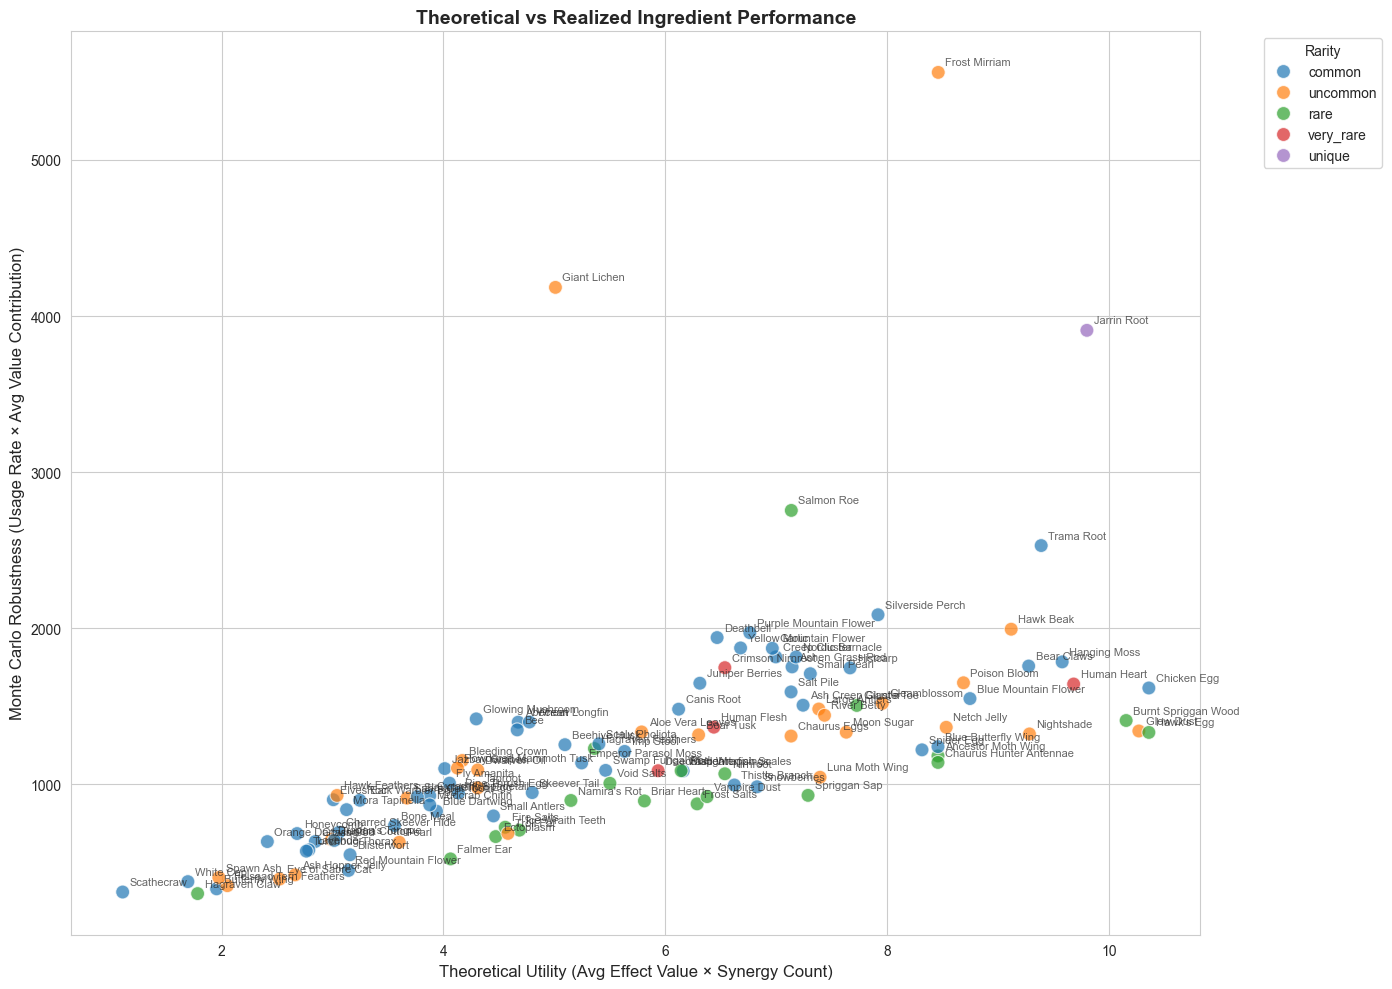

Plotted 111 ingredients


In [21]:
# Theoretical vs Realized Performance Scatter Plot
print("Creating Theoretical vs Realized Performance scatter plot...")

# Merge theoretical utility (from earlier analysis) with Monte Carlo robustness
theoretical_utility = {name: data['avg_utility'] for name, data in ingredients_data.items()}
mc_robustness = {name: data['robustness_score'] for name, data in ingredient_robustness.items()}

# Build plot dataframe
plot_data = []
for ing_name in theoretical_utility:
    if ing_name in mc_robustness:
        ing = ing_db.get_ingredient(ing_name)
        plot_data.append({
            'ingredient': ing_name,
            'theoretical_utility': theoretical_utility[ing_name],
            'mc_robustness': mc_robustness[ing_name],
            'rarity': ing.rarity
        })

plot_df = pd.DataFrame(plot_data)

# Create scatter plot
plt.figure(figsize=(14, 10))
sns.scatterplot(data=plot_df, x='theoretical_utility', y='mc_robustness', 
               hue='rarity', s=100, alpha=0.7)
plt.xlabel('Theoretical Utility (Avg Effect Value × Synergy Count)', fontsize=12)
plt.ylabel('Monte Carlo Robustness (Usage Rate × Avg Value Contribution)', fontsize=12)
plt.title('Theoretical vs Realized Ingredient Performance', fontsize=14, fontweight='bold')
plt.legend(title='Rarity', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate top outliers (ingredients where MC robustness >> theoretical utility)
threshold_ratio = 1.5
for _, row in plot_df.iterrows():
    if row['theoretical_utility'] > 0 and row['mc_robustness'] > threshold_ratio * row['theoretical_utility']:
        plt.annotate(row['ingredient'], 
                    (row['theoretical_utility'], row['mc_robustness']),
                    fontsize=8, alpha=0.7, 
                    xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

print(f"Plotted {len(plot_df)} ingredients")

Creating effect co-occurrence heatmap...


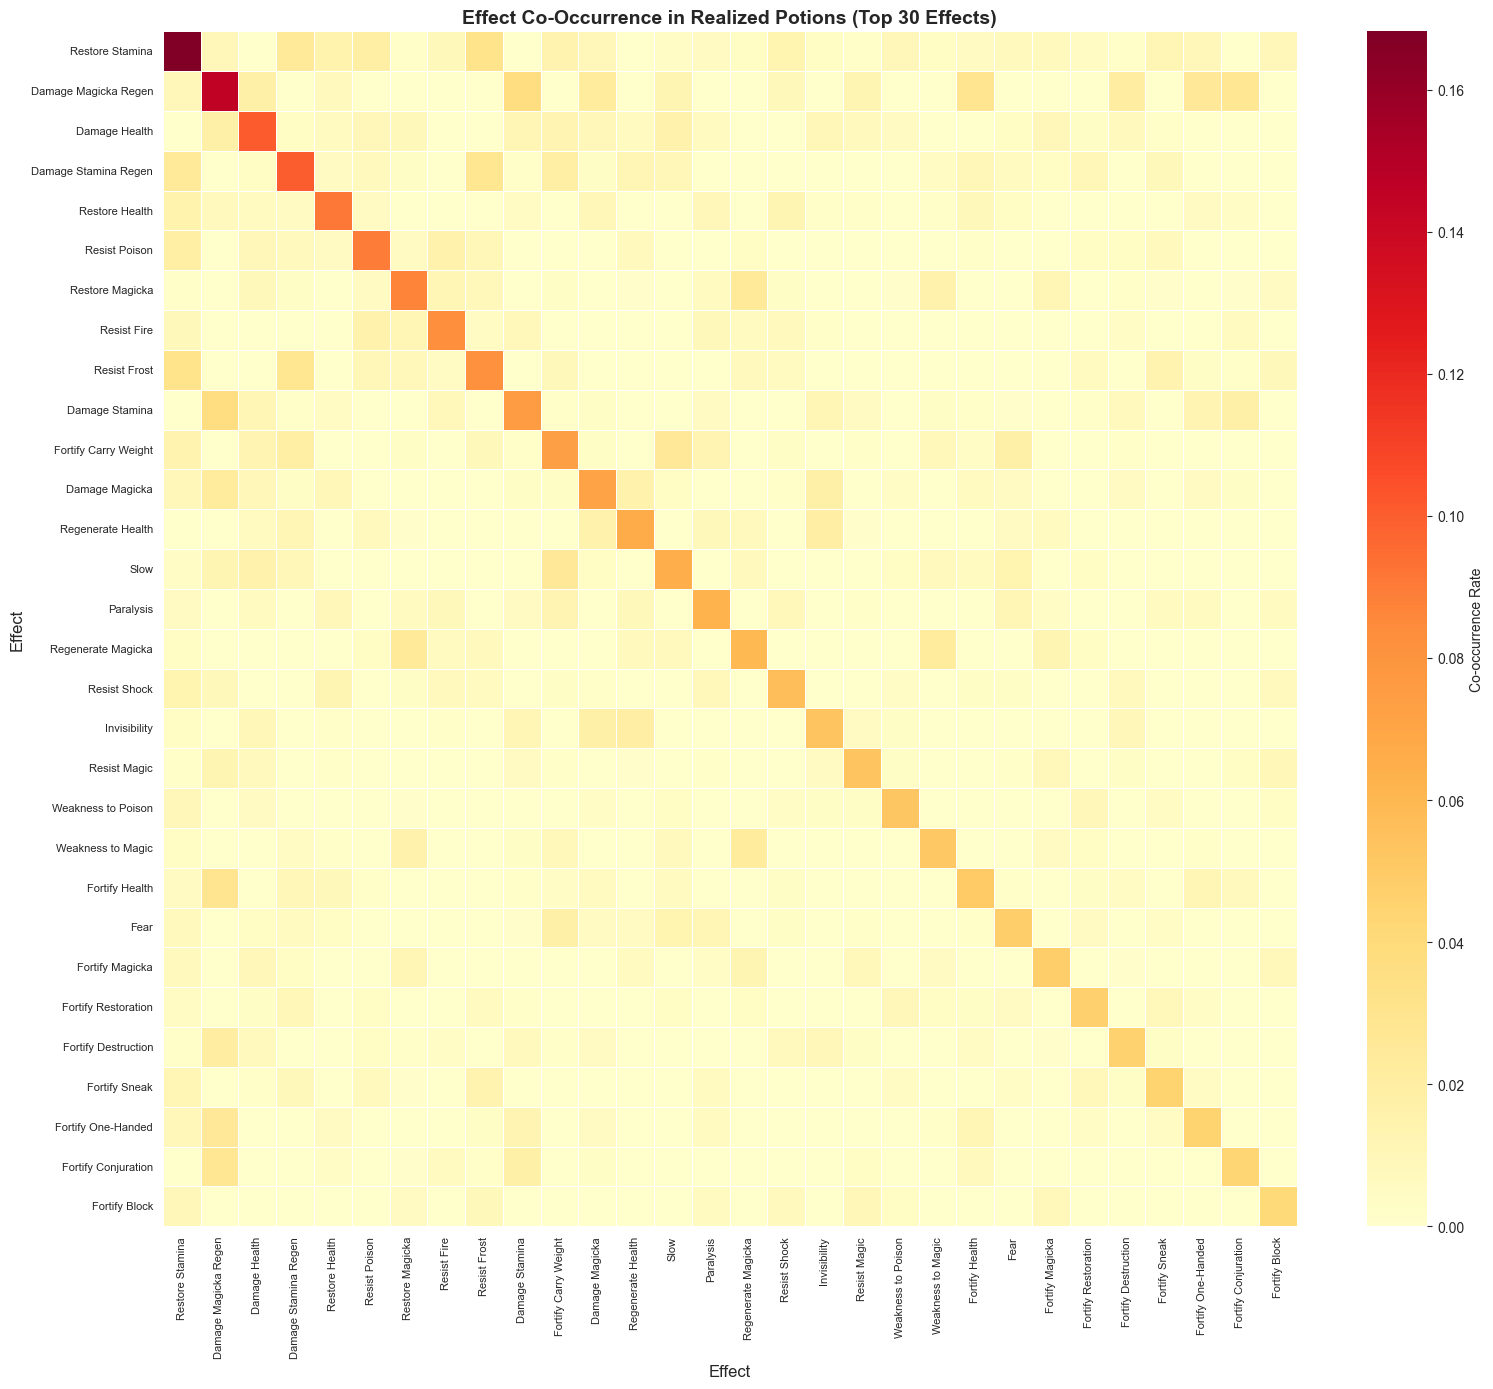

Heatmap showing co-occurrence of top 30 effects across 41187 potions


In [22]:
# Effect Co-Occurrence Heatmap
print("Creating effect co-occurrence heatmap...")

# Build effect co-occurrence matrix from realized potions
effect_names = sorted(monte_carlo_results['effect_tracking'].keys())
n = len(effect_names)
cooccurrence_matrix = np.zeros((n, n))

# Count co-occurrences
for potion in monte_carlo_results['potion_results']:
    effect_set = [e.name for e in potion.realized_effects]
    for i, eff1 in enumerate(effect_names):
        for j, eff2 in enumerate(effect_names):
            if eff1 in effect_set and eff2 in effect_set:
                cooccurrence_matrix[i, j] += 1

# Normalize by total potions
total_potions = len(monte_carlo_results['potion_results'])
cooccurrence_matrix /= total_potions

# Create heatmap (show top 30 effects for readability)
top_effects = sorted(monte_carlo_results['effect_tracking'].items(), 
                    key=lambda x: x[1]['potion_appearances'], 
                    reverse=True)[:30]
top_effect_names = [name for name, _ in top_effects]

# Filter matrix to top effects
top_indices = [effect_names.index(name) for name in top_effect_names]
filtered_matrix = cooccurrence_matrix[np.ix_(top_indices, top_indices)]

plt.figure(figsize=(16, 14))
sns.heatmap(filtered_matrix, xticklabels=top_effect_names, yticklabels=top_effect_names,
           cmap='YlOrRd', cbar_kws={'label': 'Co-occurrence Rate'}, linewidths=0.5)
plt.title('Effect Co-Occurrence in Realized Potions (Top 30 Effects)', fontsize=14, fontweight='bold')
plt.xlabel('Effect', fontsize=12)
plt.ylabel('Effect', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print(f"Heatmap showing co-occurrence of top 30 effects across {total_potions} potions")

Creating value distribution box plot...


/var/folders/2l/rz8ydl4561x3wb2q0wms5w540000gn/T/ipykernel_44617/2316686903.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=['Normal', 'Weighted', 'Vendor'], patch_artist=True)


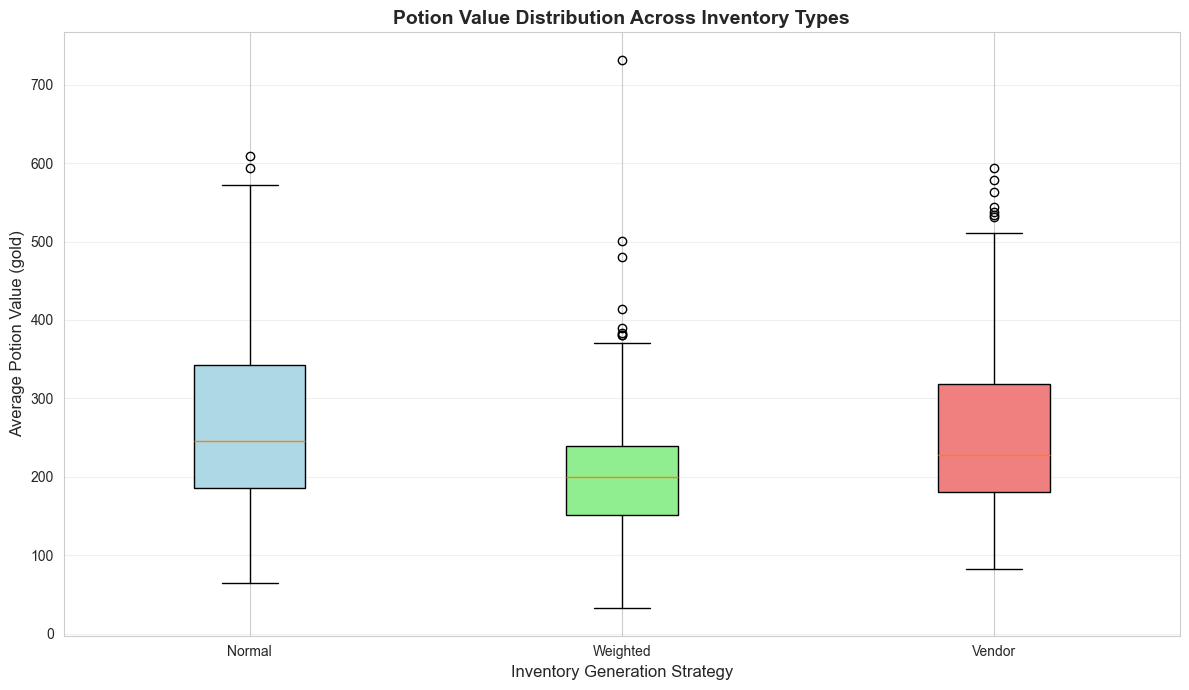

Box plot showing value distribution across 1000 runs


In [23]:
# Value Distribution Box Plot
print("Creating value distribution box plot...")

# Prepare data for box plot
value_distributions = {
    'normal': [],
    'random_weighted': [],
    'vendor': []
}

for run_meta in monte_carlo_results['run_metadata']:
    avg_potion_value = run_meta['total_value'] / run_meta['potions_count'] if run_meta['potions_count'] > 0 else 0
    value_distributions[run_meta['inv_strategy']].append(avg_potion_value)

# Create box plot
plt.figure(figsize=(12, 7))
box_data = [value_distributions['normal'], 
            value_distributions['random_weighted'],
            value_distributions['vendor']]
bp = plt.boxplot(box_data, labels=['Normal', 'Weighted', 'Vendor'], patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Average Potion Value (gold)', fontsize=12)
plt.xlabel('Inventory Generation Strategy', fontsize=12)
plt.title('Potion Value Distribution Across Inventory Types', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Box plot showing value distribution across {MC_CONFIG['num_runs']} runs")

Creating perk sensitivity bar chart...


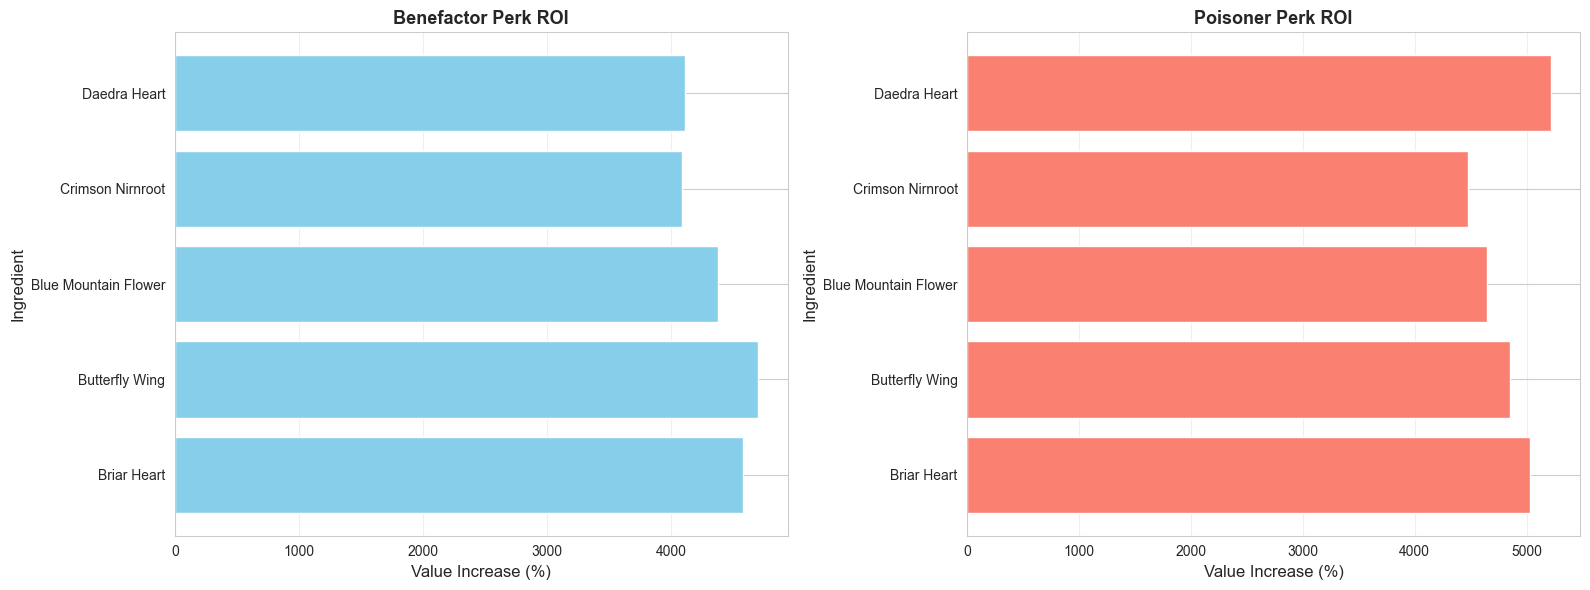

Bar chart showing perk ROI for 5 test ingredients


In [24]:
# Perk Sensitivity Bar Chart
print("Creating perk sensitivity bar chart...")

# Calculate perk ROI for all test ingredients
perk_roi_data = []
for ing_name, archetypes in perk_sensitivity_results.items():
    novice_value = archetypes['novice']['total_value']
    benefactor_value = archetypes['benefactor']['total_value']
    poisoner_value = archetypes['poisoner']['total_value']
    
    benefactor_roi = 100 * (benefactor_value - novice_value) / novice_value if novice_value > 0 else 0
    poisoner_roi = 100 * (poisoner_value - novice_value) / novice_value if novice_value > 0 else 0
    
    perk_roi_data.append({
        'ingredient': ing_name,
        'benefactor_roi': benefactor_roi,
        'poisoner_roi': poisoner_roi
    })

roi_df = pd.DataFrame(perk_roi_data)

# Create horizontal bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Benefactor ROI
ax1.barh(roi_df['ingredient'], roi_df['benefactor_roi'], color='skyblue')
ax1.set_xlabel('Value Increase (%)', fontsize=12)
ax1.set_ylabel('Ingredient', fontsize=12)
ax1.set_title('Benefactor Perk ROI', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Poisoner ROI
ax2.barh(roi_df['ingredient'], roi_df['poisoner_roi'], color='salmon')
ax2.set_xlabel('Value Increase (%)', fontsize=12)
ax2.set_ylabel('Ingredient', fontsize=12)
ax2.set_title('Poisoner Perk ROI', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Bar chart showing perk ROI for {len(perk_roi_data)} test ingredients")

## Section 5: Insights & Export

In [25]:
# Top Performers Report
print("TOP 20 INGREDIENTS BY MONTE CARLO ROBUSTNESS:")
print("=" * 70)
sorted_ingredients = sorted(ingredient_robustness.items(), 
                           key=lambda x: x[1]['robustness_score'], 
                           reverse=True)[:20]

for i, (ing_name, metrics) in enumerate(sorted_ingredients, 1):
    ing = ing_db.get_ingredient(ing_name)
    print(f"\n{i}. {ing_name} ({ing.rarity})")
    print(f"   Appearance rate: {metrics['appearance_rate']:.1%}")
    print(f"   Usage rate: {metrics['usage_rate']:.1%}")
    print(f"   Avg value contribution: {metrics['avg_value_contribution']:.1f} gold")
    print(f"   Robustness score: {metrics['robustness_score']:.2f}")

# Print most reliable synergy pairs
print("\n\nTOP 20 SYNERGY PAIRS BY CO-USAGE ROBUSTNESS:")
print("=" * 70)
sorted_pairs = sorted(synergy_performance.items(), 
                     key=lambda x: x[1]['pair_robustness'], 
                     reverse=True)[:20]

for i, (pair, metrics) in enumerate(sorted_pairs, 1):
    print(f"\n{i}. {pair[0]} + {pair[1]}")
    print(f"   Co-usage count: {metrics['co_usage_count']}")
    print(f"   Avg pair value: {metrics['avg_pair_value']:.1f} gold")
    print(f"   Pair robustness: {metrics['pair_robustness']:.3f}")

TOP 20 INGREDIENTS BY MONTE CARLO ROBUSTNESS:

1. Frost Mirriam (uncommon)
   Appearance rate: 26.1%
   Usage rate: 99.2%
   Avg value contribution: 5603.9 gold
   Robustness score: 5560.92

2. Giant Lichen (uncommon)
   Appearance rate: 25.8%
   Usage rate: 98.8%
   Avg value contribution: 4233.0 gold
   Robustness score: 4183.78

3. Jarrin Root (unique)
   Appearance rate: 11.1%
   Usage rate: 100.0%
   Avg value contribution: 3908.6 gold
   Robustness score: 3908.62

4. Salmon Roe (rare)
   Appearance rate: 23.4%
   Usage rate: 98.7%
   Avg value contribution: 2790.8 gold
   Robustness score: 2755.03

5. Trama Root (common)
   Appearance rate: 25.0%
   Usage rate: 98.8%
   Avg value contribution: 2560.6 gold
   Robustness score: 2529.87

6. Silverside Perch (common)
   Appearance rate: 24.7%
   Usage rate: 99.6%
   Avg value contribution: 2095.1 gold
   Robustness score: 2086.66

7. Hawk Beak (uncommon)
   Appearance rate: 23.9%
   Usage rate: 99.6%
   Avg value contribution: 2002.4

In [26]:
# Export Results to JSON
import json

print("Exporting results to JSON...")

export_data = {
    'ingredient_robustness': ingredient_robustness,
    'effect_performance': effect_performance,
    'synergy_performance': {f"{p[0]}+{p[1]}": v for p, v in synergy_performance.items()},
    'run_summary': {
        'total_runs': MC_CONFIG['num_runs'],
        'total_potions_crafted': sum(r['potions_count'] for r in monte_carlo_results['run_metadata']),
        'avg_value_per_run': np.mean([r['total_value'] for r in monte_carlo_results['run_metadata']]),
        'avg_potions_per_run': np.mean([r['potions_count'] for r in monte_carlo_results['run_metadata']])
    }
}

with open('monte_carlo_results.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("Results exported to monte_carlo_results.json")
print(f"\nSummary:")
print(f"  Total runs: {export_data['run_summary']['total_runs']}")
print(f"  Total potions crafted: {export_data['run_summary']['total_potions_crafted']}")
print(f"  Avg value per run: {export_data['run_summary']['avg_value_per_run']:.1f} gold")
print(f"  Avg potions per run: {export_data['run_summary']['avg_potions_per_run']:.1f}")

Exporting results to JSON...
Results exported to monte_carlo_results.json

Summary:
  Total runs: 1000
  Total potions crafted: 41187
  Avg value per run: 10789.1 gold
  Avg potions per run: 41.2
